## Introduction

For our project we are analyzing the dataset of all flights that departed from the three main New York City airports in 2023. For this project we will be analyzing all the features of the dataset and from the auxiliary ones. Our target variable for regression is 'arr_delay' and for classification we have chosen cancellation prediction. When we don't have information about departure or arrival time it means that the flight was cancelled.

## Data Cleaning

Overview of datasets:
* airlines.csv
    * `carrier` -- Two-letter airline code.
    * `name` -- Full name of the airline.

* airports.csv
    * `faa` -- FAA code of the airport (e.g., JFK for John F. Kennedy).
    * `name` -- Name of the airport.
    * `lat` -- Latitude of the airport (decimal format).
    * `lon` -- Longitude of the airport (decimal format).
    * `alt` -- Altitude of the airport in feet.
    * `tz` -- Time zone offset (UTC offset). Can be `null`
    * `dst` -- Daylight saving time indicator (`A` = Active, etc.). Can be `null` but it is `null` iff `tz` is `null`
    * `tzone` -- IANA time zone name (e.g., America/New_York). Can be `null` but it is `null` in superset of cases when `tz` is null, therefore can be filled sometimes with already existing values

* flights.csv
    * `year` -- Year of the flight. Always `2023`, therefore dropped
    * `month` -- Month of the flight.
    * `day` -- Day of the flight.
    * `dep_time` -- Actual departure time (local, in military format). Can be `null`
    * `sched_dep_time` -- Scheduled departure time (local, in military format).
    * `dep_delay` -- Departure delay in minutes (negative if early). Can be `null` iff `dep_time` is null
    * `arr_time` -- Actual arrival time (local, in military format). Can be `null` in superset of cases when `dep_delay` is `null`. If it is `null` we assume that flight was cancelled.
    * `sched_arr_time` -- Scheduled arrival time (local, in military format).
    * `arr_delay` -- Arrival delay in minutes (negative if early). Can be `null` in superset of cases when `arr_time` is `null`. Can be filled in as difference between `sched_arr_time` and `arr_time`
    * `carrier` -- Two-letter airline code (links to `airlines.csv`).
    * `flight` -- Flight number.
    * `tailnum` -- Aircraft tail number (links to `planes.csv`). Cna be `null` but number is small => can be dropped.
    * `origin` -- Origin airport code (links to `airports.csv`).
    * `dest` -- Destination airport code (links to `airports.csv`).
    * `air_time` -- Total air time in minutes. Can be `null` iff `arr_delay` is null but we decided not to use this column => can be ignored.
    * `distance` -- Distance of the flight in miles.
    * `hour` -- Scheduled departure hour (derived from `sched_dep_time`).
    * `minute` -- Scheduled departure minute (derived from `sched_dep_time`).
    * `time_hour` -- Rounded time to the nearest hour (useful for joining with weather data).

* planes.csv
    * `tailnum` -- Unique aircraft identifier (matches with `flights.tailnum`).
    * `year` -- Year the plane was manufactured. Can be `null` but it is quite rare case, therefore can be dropped
    * `type` -- Aircraft type (e.g., "Fixed wing multi engine").
    * `manufacturer` -- Manufacturer of the aircraft (e.g., Boeing, Airbus).
    * `model` -- Model of the aircraft (e.g., "A320").
    * `engines` -- Number of engines on the aircraft.
    * `seats` -- Number of passenger seats on the plane. Always `0`, therefore dropped
    * `speed` -- Typical cruise speed (if available; may be NaN).
    * `engine` -- Type of engine (e.g., "Turbo-fan").

* weather.csv
    * `origin` -- Airport code where the weather data is recorded (links to `airports.faa`).
    * `year` -- Year of the weather record.
    * `month` -- Month of the weather record.
    * `day` -- Day of the weather record.
    * `hour` -- Hour of the weather observation (local).
    * `temp` -- Temperature in degrees Fahrenheit. Can be `null` in superset of cases when `precip` is `null`
    * `dewp` -- Dewpoint temperature in degrees Fahrenheit. Can be `null` iff `temp` is `null`
    * `humid` -- Relative humidity (%). Can be `null` iff `temp` is `null`
    * `wind_dir` -- Wind direction in degrees (0° = North, 90° = East, etc.).
    * `wind_speed` -- Wind speed in mph.
    * `wind_gust` -- Wind gust speed in mph (if available).
    * `precip` -- Precipitation in inches. Can be `null`.
    * `pressure` -- Atmospheric pressure in millibars (if available). Can be `null` in superset of cases when `temp` is `null`
    * `visib` -- Visibility in miles.
    * `time_hour` -- Time of the observation rounded to the nearest hour (links to `flights.time_hour`).



### Imports

In [810]:
import numpy as np

!pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [811]:
import pandas as pd
from matplotlib import pyplot as plt

### Load datasets

In [812]:
def read_csv(filename):
    df = pd.read_csv(
        filename,
        header=0,                     # Use the first row as the header
        delimiter=';',                # Use semicolon as the main delimiter
        decimal=',',                  # Specify that commas are used as decimals
        quotechar='"',                # Handle quotes around strings
        skipinitialspace=True,        # Skip spaces after delimiters
    )
    df.set_index(df.columns[0], inplace=True)
    return df

airlines = read_csv('airlines.csv')
airports = read_csv('airports.csv')
planes = read_csv('planes.csv')
flights = read_csv('flights.csv')
weather = read_csv('weather.csv')

In [813]:
planes['year'] = planes['year'].astype('Int64')
flights['dep_time'] = flights['dep_time'].astype('Int64')
flights['dep_delay'] = flights['dep_delay'].astype('Int64')
flights['arr_time'] = flights['arr_time'].astype('Int64')
flights['arr_delay'] = flights['arr_delay'].astype('Int64')

In [814]:
def check_for_nulls(df):
    res = {}
    for c in df.columns:
        if df[df[c].isnull()].shape[0] != 0:
            res[c] = df[df[c].isnull()].shape[0]
    return res

In [815]:
print("Nullable columns in airlines:", check_for_nulls(airlines))
print("Nullable columns in airports:", check_for_nulls(airports))
print("Nullable columns in planes:", check_for_nulls(planes))
print("Nullable columns in flights:", check_for_nulls(flights))
print("Nullable columns in weather:", check_for_nulls(weather))

Nullable columns in airlines: {}
Nullable columns in airports: {'tz': 48, 'dst': 48, 'tzone': 119}
Nullable columns in planes: {'year': 89}
Nullable columns in flights: {'dep_time': 10738, 'dep_delay': 10738, 'arr_time': 11453, 'arr_delay': 12534, 'tailnum': 1913, 'air_time': 12534}
Nullable columns in weather: {'temp': 25536, 'dewp': 25536, 'humid': 25536, 'wind_dir': 1220, 'wind_speed': 1033, 'wind_gust': 1033, 'precip': 24611, 'pressure': 25632, 'visib': 24}


### Clean Datasets

In [816]:
def clear_airports(df): # fill `tzone` if it can be filled, drop otherwise. If `tz` is unknown, drop
    df = df.dropna(subset=['tz', 'dst'])

    for idx, row in df[df['tzone'].isnull()].iterrows():
        matching_row = df[(df['tz'] == row['tz']) & pd.notnull(df['tzone'])]
        if not matching_row.empty:
            df.at[idx, 'tzone'] = matching_row['tzone'].iloc[0]
        else:
            df = df.drop(idx)
    return df

In [817]:
def clear_planes(df): # drop all planes if `year` is unknown
    return df.dropna()

In [818]:
def clear_flights(df): # drop if `tailnum` is unknown, fix military format of time, fill air_time where needed
    df = df.dropna(subset=['tailnum'])

    for idx, row in df.iterrows():
        df.at[idx, 'dep_time'] = df.at[idx, 'dep_time'] % 100 + (df.at[idx, 'dep_time'] // 100) * 60
        df.at[idx, 'arr_time'] = df.at[idx, 'arr_time'] % 100 + (df.at[idx, 'arr_time'] // 100) * 60
        df.at[idx, 'sched_dep_time'] = df.at[idx, 'sched_dep_time'] % 100 + (df.at[idx, 'sched_dep_time'] // 100) * 60
        df.at[idx, 'sched_arr_time'] = df.at[idx, 'sched_arr_time'] % 100 + (df.at[idx, 'sched_arr_time'] // 100) * 60

    for idx, row in df[df['air_time'].isnull()].iterrows():
        df.at[idx, 'arr_delay'] = df['arr_time'].iloc[0] - df['sched_arr_time'].iloc[0]
        df.at[idx, 'air_time'] = df['arr_time'].iloc[0] - df['dep_time'].iloc[0]
    return df

In [819]:
def clear_weather(df): # here we ignore all nulls and keep them as is
    return df

In [820]:
clean_airlines = airlines
clean_airports = clear_airports(airports.copy())
clean_planes = clear_planes(planes.copy())
clean_flights = clear_flights(flights.copy())
clean_weather = clear_weather(weather.copy())

In [821]:
print("Nullable columns in airlines:", check_for_nulls(clean_airlines))
print("Nullable columns in airports:", check_for_nulls(clean_airports))
print("Nullable columns in planes:", check_for_nulls(clean_planes))
print("Nullable columns in flights:", check_for_nulls(clean_flights))
print("Nullable columns in weather:", check_for_nulls(clean_weather))

Nullable columns in airlines: {}
Nullable columns in airports: {}
Nullable columns in planes: {}
Nullable columns in flights: {'dep_time': 8825, 'dep_delay': 8825, 'arr_time': 9540}
Nullable columns in weather: {'temp': 25536, 'dewp': 25536, 'humid': 25536, 'wind_dir': 1220, 'wind_speed': 1033, 'wind_gust': 1033, 'precip': 24611, 'pressure': 25632, 'visib': 24}


In [822]:
print("Airports old vs new:", airports.shape, clean_airports.shape)
print("Planes old vs new:", planes.shape, clean_planes.shape)
print("Flights old vs new:", flights.shape, clean_flights.shape)
print("Weather old vs new:", weather.shape, clean_weather.shape)

Airports old vs new: (1251, 8) (1194, 8)
Planes old vs new: (4840, 9) (4751, 9)
Flights old vs new: (435352, 19) (433439, 19)
Weather old vs new: (26204, 15) (26204, 15)


### Merge datasets

In [823]:
# merge flights with info about origin airport
flights_with_origin_info = pd.merge(
    clean_flights,
    clean_airports,
    how='left',
    left_on='origin',
    right_on='faa',
    suffixes=('', '_origin')
)

# merge obtained dataset with info about destination airport
flights_with_origin_and_dest = pd.merge(
    flights_with_origin_info,
    clean_airports,
    how='inner',
    left_on='dest',
    right_on='faa',
    suffixes=('_origin', '_dest')
)

# merge obtained dataset with info about plane
flights_with_origin_dest_and_planes = pd.merge(
    flights_with_origin_and_dest,
    clean_planes,
    how='left',
    left_on=['tailnum'],
    right_on=['tailnum'],
    suffixes=('', '_plane')
)

# merge obtained dataset with info about weather at the departure time
merged_df = pd.merge(
    flights_with_origin_dest_and_planes,
    clean_weather,
    how='left',
    left_on=['origin', 'year', 'month', 'day', 'hour'],
    right_on=['origin', 'year', 'month', 'day', 'hour'],
    suffixes=('', '_weather')
)

In [824]:
merged_df['is_cancelled'] = merged_df['arr_time'].isnull()

# drop columns that are not needed for classification and regression
merged_df = merged_df.drop(['arr_time', 'flight', 'tailnum', 'air_time', 'time_hour', 'faa_origin', 'name_origin', 'lat_origin', 'lon_origin', 'alt_origin', 'tz_origin', 'dst_origin', 'tzone_origin', 'faa_dest', 'name_dest', 'dst_dest', 'tzone_dest', 'time_hour_weather', 'year', 'speed', 'hour', 'minute'], axis=1)

In [825]:
merged_df.to_csv("merged_df.csv", index=False)

In [826]:
# split into 3 datasets depending on origin airport
ewr_df = merged_df[merged_df['origin'] == 'EWR'].drop('origin', axis=1)
jfk_df = merged_df[merged_df['origin'] == 'JFK'].drop('origin', axis=1)
lga_df = merged_df[merged_df['origin'] == 'LGA'].drop('origin', axis=1)

In [827]:
# process each dataset and create datasets for both classification and regression task
ewr_delay_df = ewr_df.drop('is_cancelled', axis=1).dropna(subset=['arr_delay'])
ewr_cancel_df = ewr_df.drop(['dep_delay', 'arr_delay'], axis=1)
jfk_delay_df = jfk_df.drop('is_cancelled', axis=1).dropna(subset=['arr_delay'])
jfk_cancel_df = jfk_df.drop(['dep_delay', 'arr_delay'], axis=1)
lga_delay_df = lga_df.drop('is_cancelled', axis=1).dropna(subset=['arr_delay'])
lga_cancel_df = lga_df.drop(['dep_delay', 'arr_delay'], axis=1)

In [828]:
ewr_delay_df.to_csv("ewr_delay.csv", index=False)
jfk_delay_df.to_csv("jfk_delay.csv", index=False)
lga_delay_df.to_csv("lga_delay.csv", index=False)
ewr_cancel_df.to_csv("ewr_cancel.csv", index=False)
jfk_cancel_df.to_csv("jfk_cancel.csv", index=False)
lga_cancel_df.to_csv("lga_cancel.csv", index=False)

## Exporatory Data Analysis
### Delays

First, let's take a general look over the data distribution. To start with, how many flights are done each month and how delayed flights are distributed over them.

In [829]:
import seaborn as sns

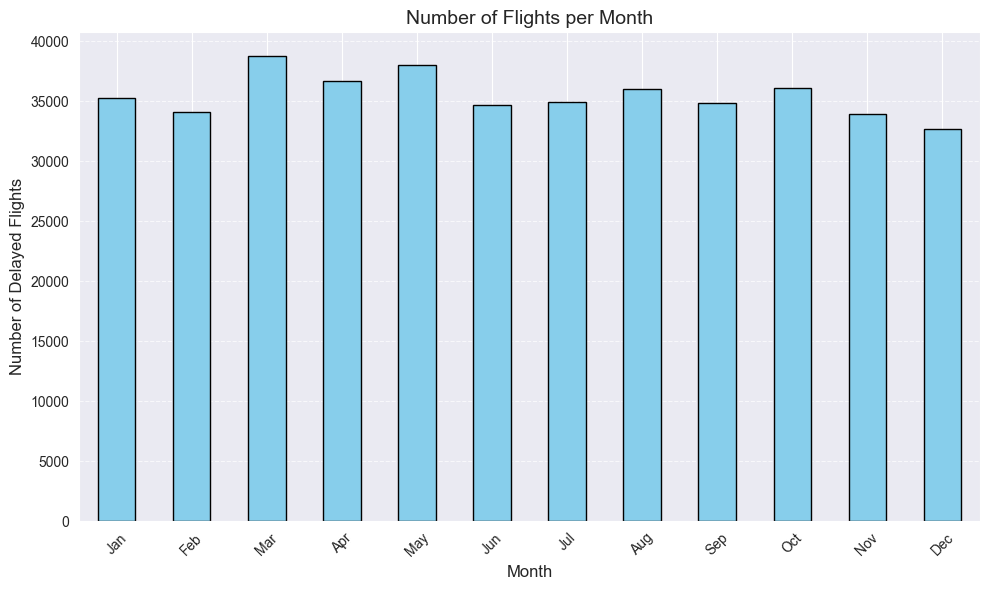

In [830]:
monthly_flights = merged_df.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_flights.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(12), labels=[f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

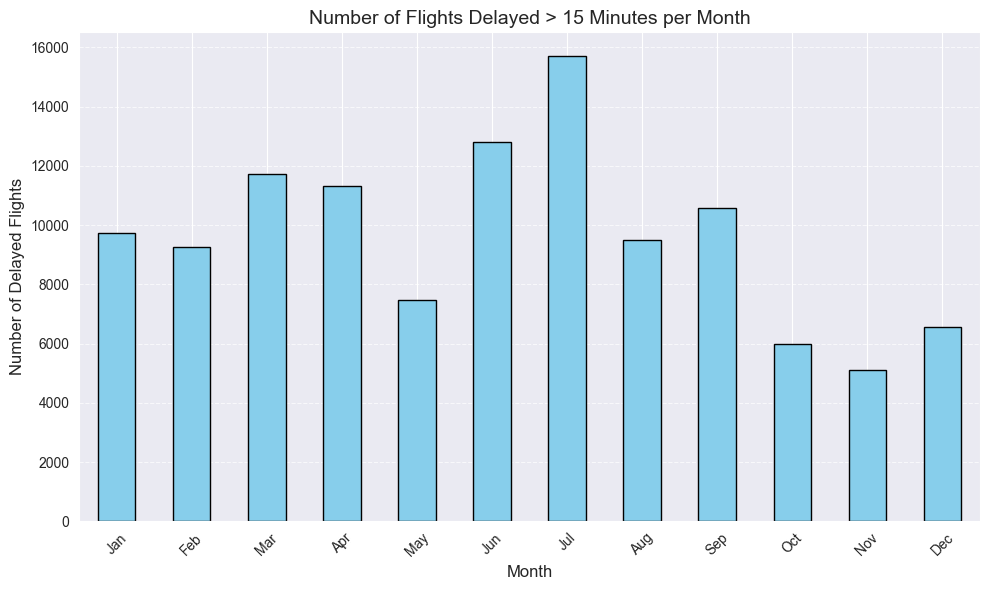

In [831]:
flights_delayed = merged_df[(merged_df['arr_delay'] > 15) | (merged_df['dep_delay'] > 15)]

monthly_delays = flights_delayed.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Delayed > 15 Minutes per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(12), labels=[f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the plot above we may try to derive some conclusions:
- It is clear that the most delays occur in the peak summer months June and July, which may be due to overall increased air traffic, congestions of airports and weather conditions
- Similarly, autumn months, when the travels are less frequent, are less affected by delays

To analyse this further, we can try to look into differences between arr_delay and dep_delay:

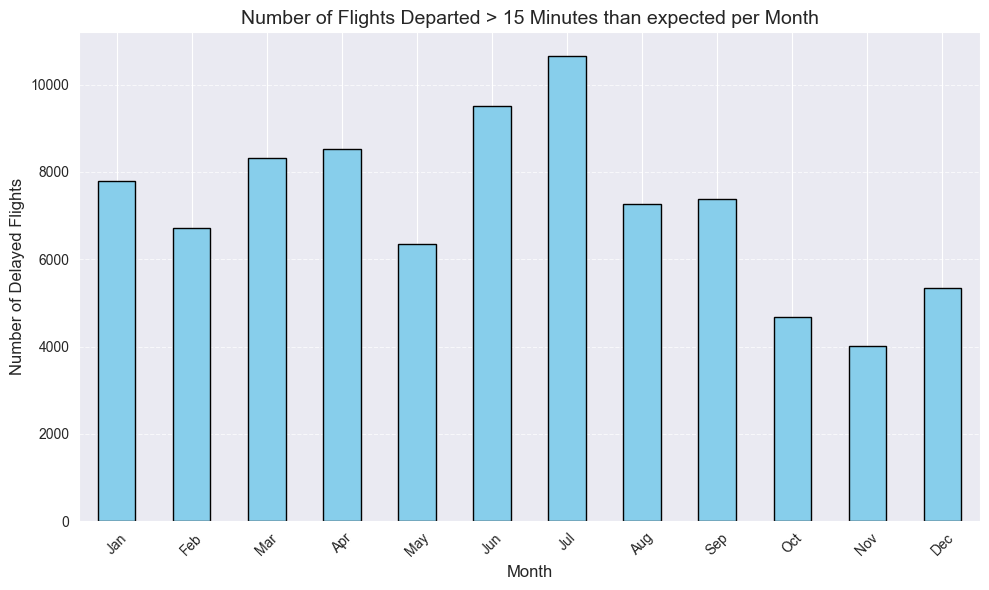

In [832]:
flights_delayed = merged_df[(merged_df['dep_delay'] > 15)]

monthly_delays = flights_delayed.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Departed > 15 Minutes than expected per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(12), labels=[f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

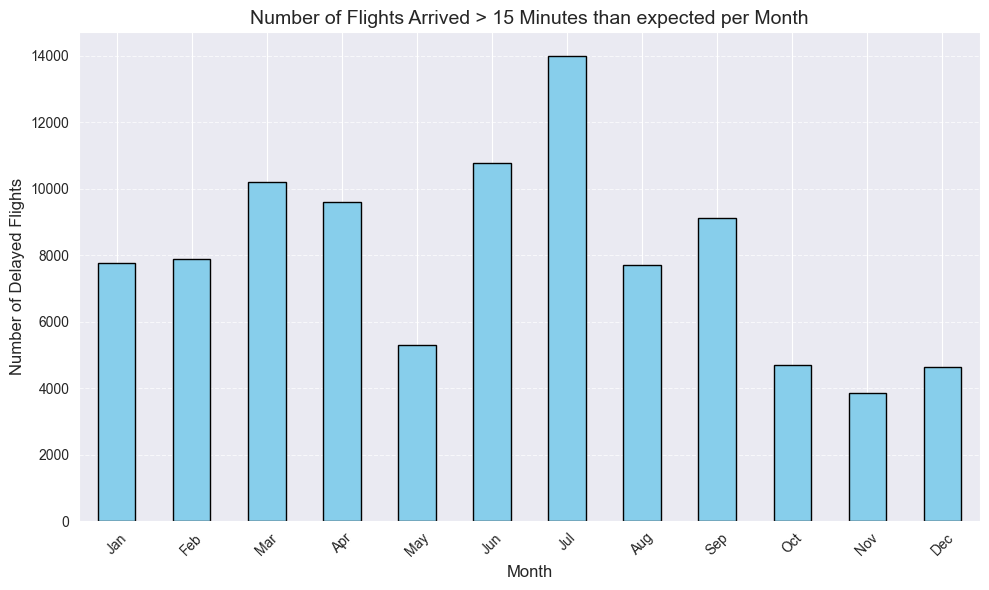

In [833]:
flights_delayed = merged_df[(merged_df['arr_delay'] > 15)]

monthly_delays = flights_delayed.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Arrived > 15 Minutes than expected per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(12), labels=[f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The plots show that in some months there is a tendency in delayed departures, but not at the identified peak months. Let's see how delayed arrivals are distributed over the source airports:

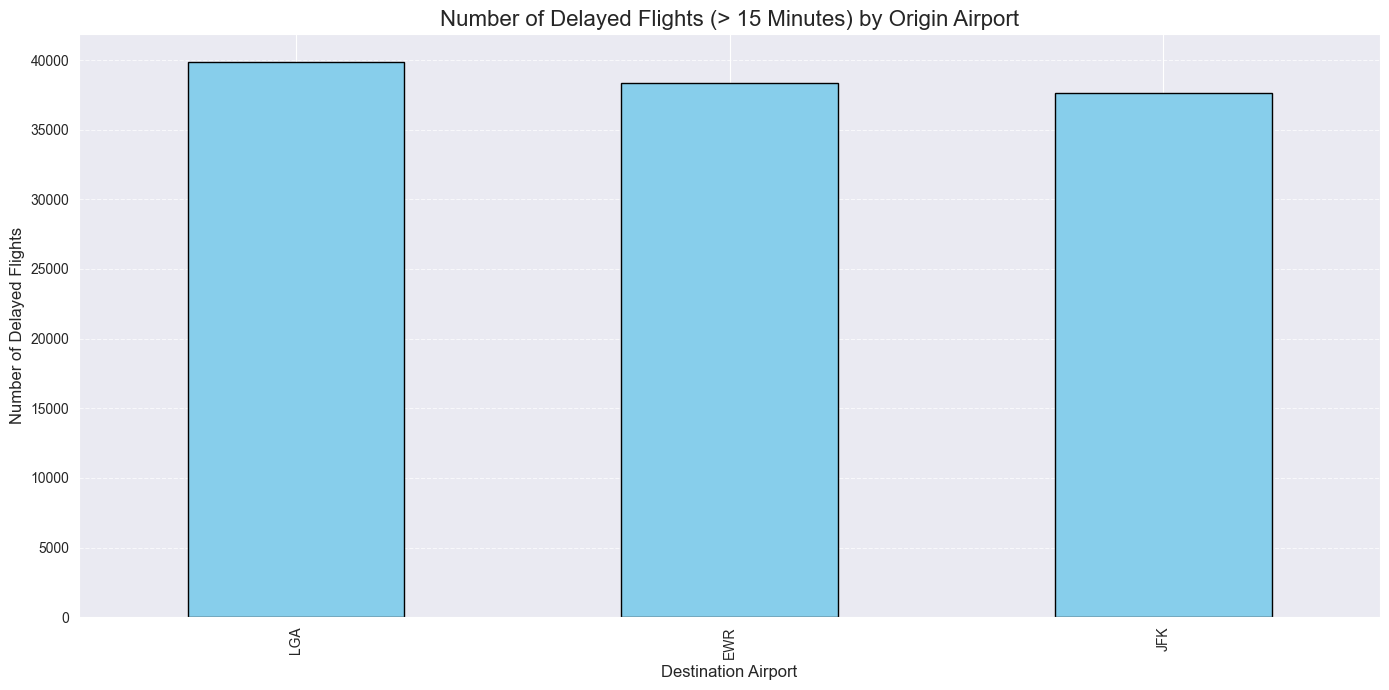

In [834]:
flights_delayed = merged_df[(merged_df['arr_delay'] > 15) | (merged_df['dep_delay'] > 15)]

delays_by_destination = flights_delayed.groupby('origin').size().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
delays_by_destination.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Delayed Flights (> 15 Minutes) by Origin Airport', fontsize=16)
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

And what are mean delays in them:

In [835]:
flights_delayed.groupby('origin')[['dep_delay', 'arr_delay']].mean().sort_values('arr_delay', ascending=False)

,dep_delay,arr_delay
origin,,
LGA,62.172694,78.683557
JFK,63.151786,76.00593
EWR,62.358344,71.41391


There is no significant difference between the origin airports in terms of delays, let's investigate the destination airports in the similar way:

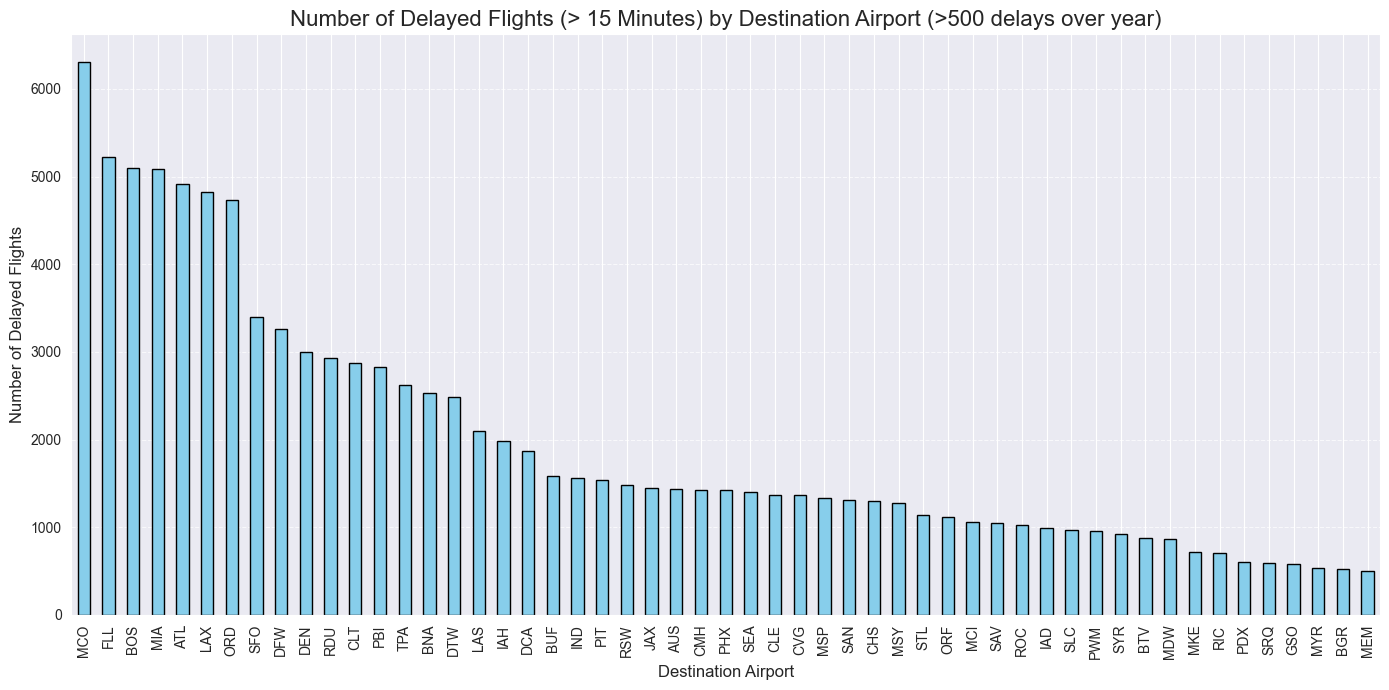

In [836]:
flights_delayed = merged_df[(merged_df['arr_delay'] > 15) | (merged_df['dep_delay'] > 15)]

delays_by_destination = flights_delayed.groupby('dest').size().sort_values(ascending=False)
delays_by_destination = delays_by_destination[delays_by_destination >= 500]

# Step 3: Plot the result
plt.figure(figsize=(14, 7))
delays_by_destination.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Delayed Flights (> 15 Minutes) by Destination Airport (>500 delays over year)', fontsize=16)
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The above plot does not contain destination airpots with less than 500 delayed flights over the year (for visual purposes). We can clearly observe a skewed distribution with several airports constituting to the most of the delays. To indicate it more formally, we can investigate cumulative percentage over Pareto threshold:

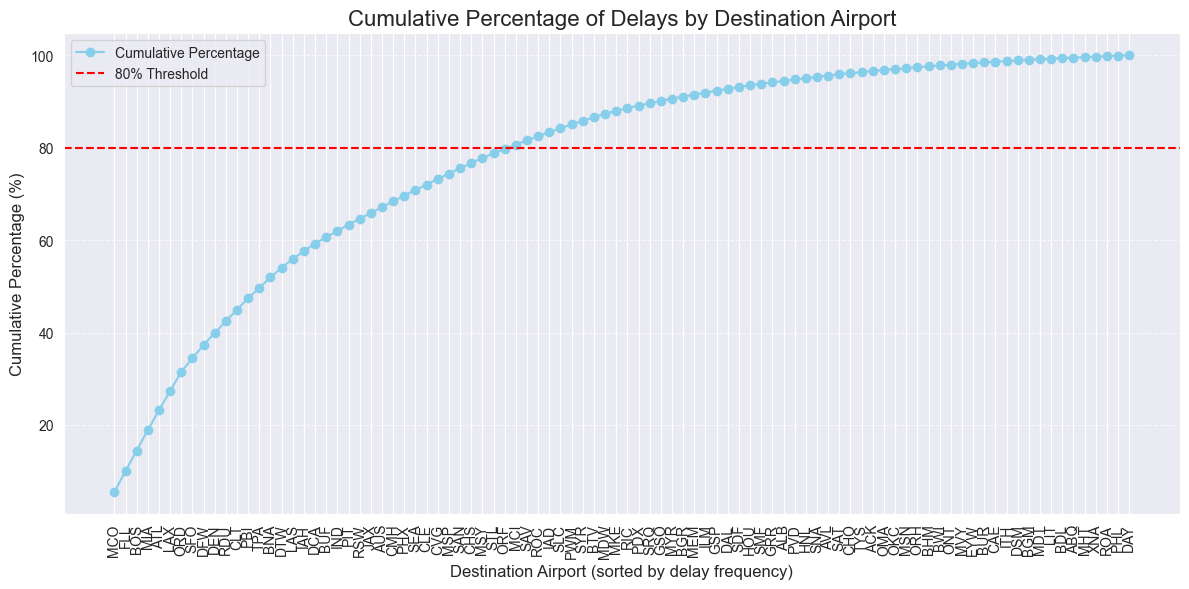

Number of destinations accounting for 80% of delays: 36 out of 92


In [837]:
delays_by_destination = flights_delayed.groupby('dest').size()
delays_by_destination = delays_by_destination[delays_by_destination >= 100].sort_values(ascending=False)

cumulative_delays = delays_by_destination.cumsum()
cumulative_percentage = 100 * cumulative_delays / cumulative_delays.iloc[-1]

plt.figure(figsize=(12, 6))
plt.plot(cumulative_percentage, marker='o', color='skyblue', label='Cumulative Percentage')
plt.axhline(y=80, color='r', linestyle='--', label='80% Threshold')

plt.title('Cumulative Percentage of Delays by Destination Airport', fontsize=16)
plt.xlabel('Destination Airport (sorted by delay frequency)', fontsize=12)
plt.ylabel('Cumulative Percentage (%)', fontsize=12)
plt.xticks(ticks=np.arange(len(cumulative_percentage)), labels=cumulative_percentage.index, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

pareto_threshold = (cumulative_percentage <= 80).sum()
print(f"Number of destinations accounting for 80% of delays: {pareto_threshold} out of {len(delays_by_destination)}")

With this, we see that around 20-30% of the airports (on the left) contribute most to the delays: after reaching 80% the curve significantly flattens. 

Similarly, by observing amount of flights for each hour of the day versus delayed flights we can see that evening hours contribute more to the delays:

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/2371217328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_delayed['dep_hour'] = flights_delayed['dep_time'] // 60


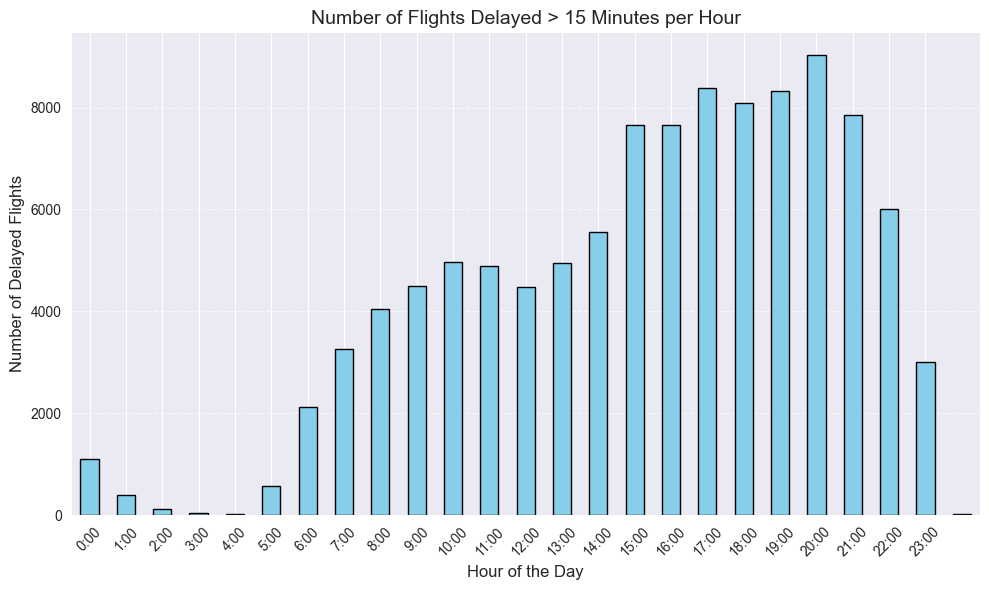

In [838]:
flights_delayed = merged_df[(merged_df['arr_delay'] > 15) | (merged_df['dep_delay'] > 15)]

flights_delayed['dep_hour'] = flights_delayed['dep_time'] // 60

hourly_delays = flights_delayed.groupby('dep_hour').size()

plt.figure(figsize=(10, 6))
hourly_delays.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Delayed > 15 Minutes per Hour', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

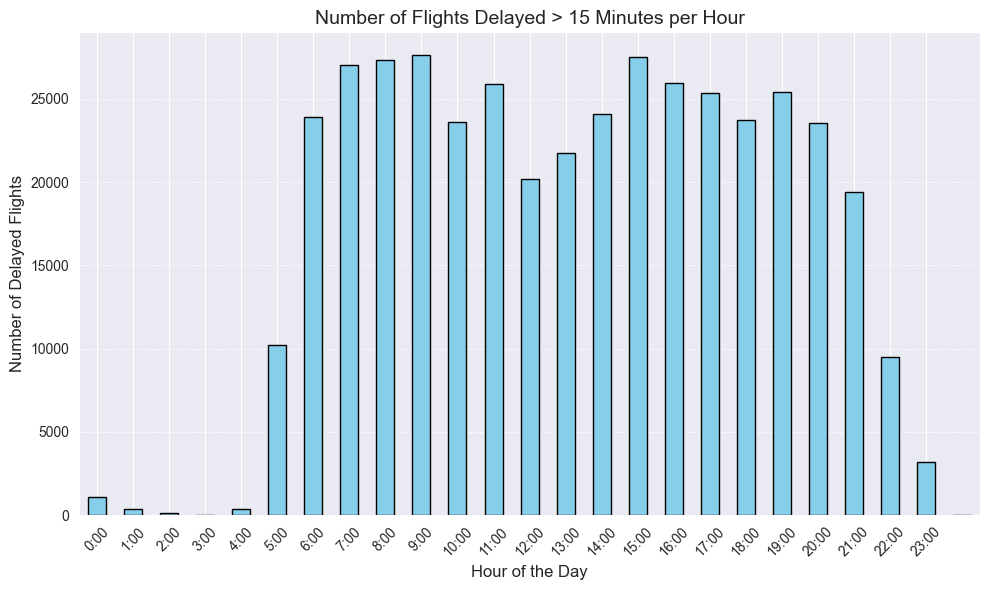

In [839]:
all_flights = merged_df
all_flights['dep_hour'] = all_flights['dep_time'] // 60

hourly_all_delays = all_flights.groupby('dep_hour').size()

plt.figure(figsize=(10, 6))
hourly_all_delays.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Delayed > 15 Minutes per Hour', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Which can be for various reasons:
- Operational congestion of accumulating delays and mismanagements throughout the day (thus the increasing of the amount of delays) 
- Less space for adjustments 
- Unequal staffing or external conditions like weather and decreased visibility in the evening hours

The weather data for the dataset mostly lacks precise temp/humidity/etc data. We can try to observe the distribution of existing to understand whether this data can be reliably used in the future investigation:

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/560336094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


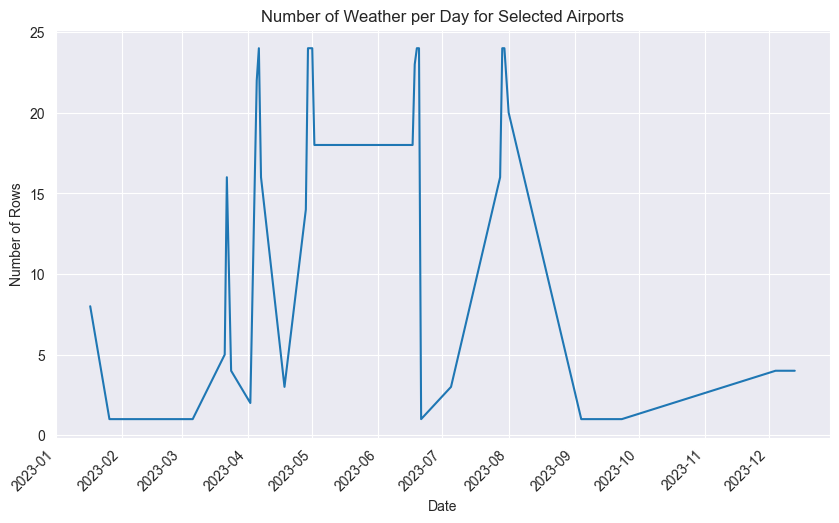

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/560336094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


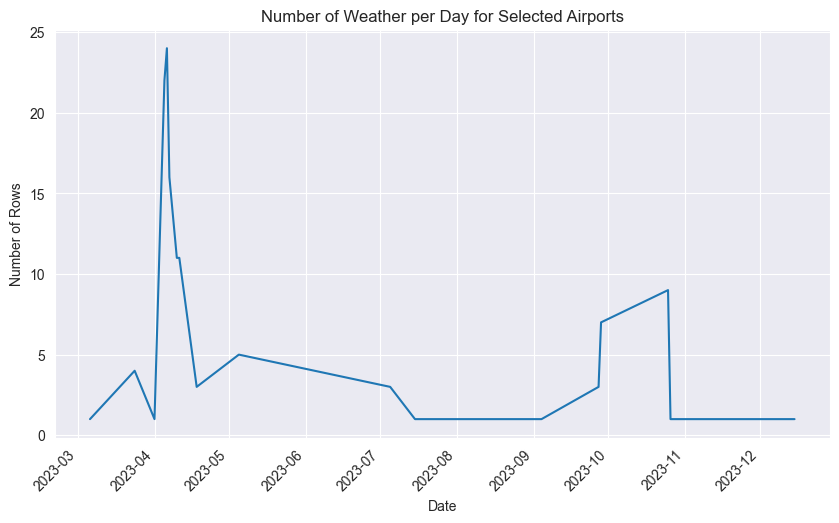

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/560336094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])


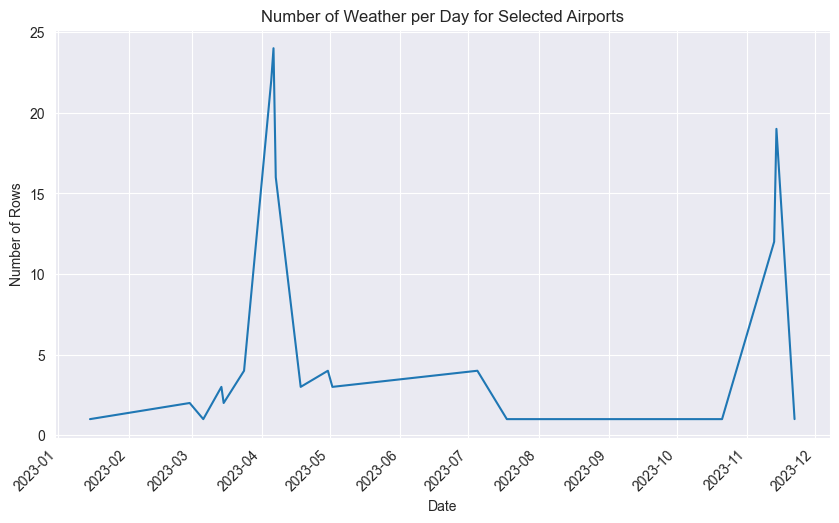

In [840]:
airports = ["JFK", "EWR", "LGA"]

for airport in airports:
    filtered_weather = clean_weather[clean_weather['origin'].eq(airport) 
                                     & clean_weather['temp'].notnull() 
                                     & clean_weather['dewp'].notnull() 
                                     & clean_weather['humid'].notnull()]
    
    filtered_weather['date'] = pd.to_datetime(filtered_weather[['year', 'month', 'day']])    
    daily_counts = filtered_weather.groupby('date').size()
    
    plt.figure(figsize=(10, 6))
    daily_counts.plot(kind='line', title='Number of Weather per Day for Selected Airports')
    plt.xlabel('Date')
    plt.ylabel('Number of Rows')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

It is clear that only a few dates during different periods have almost complete weather coverage in all three airports, which is not enough to rely on weather data when solving the problem. 

Let's observe if the delays depend on a particular carrier:

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/558046951.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df[merged_df['arr_delay'] < 100], x='carrier', y='arr_delay', palette="Set2")


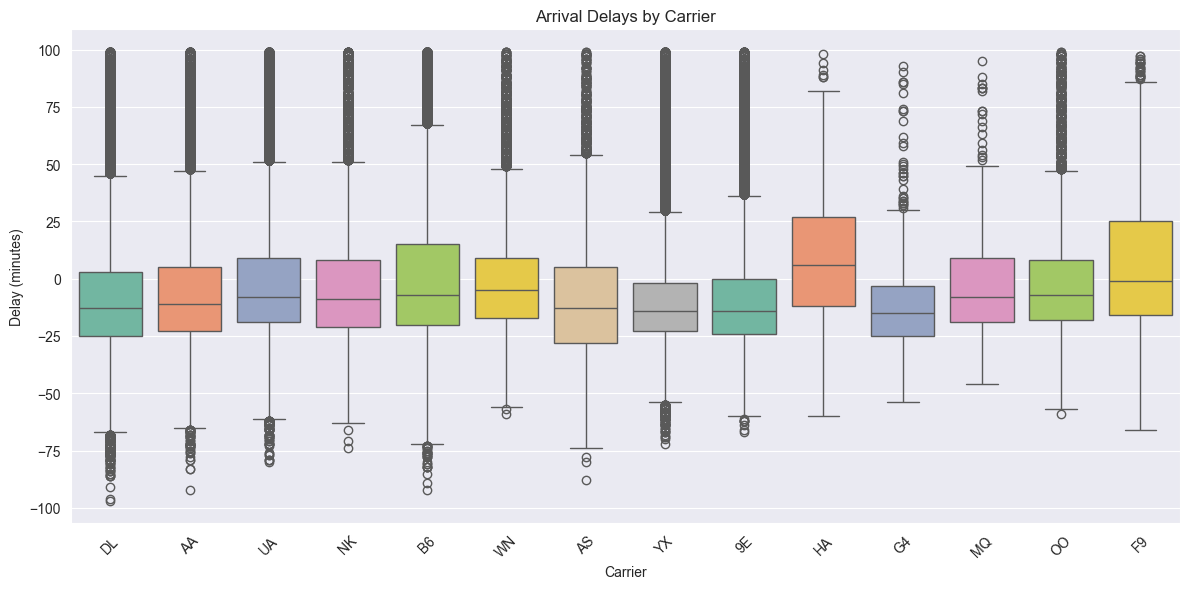

In [841]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[merged_df['arr_delay'] < 100], x='carrier', y='arr_delay', palette="Set2")

plt.title("Arrival Delays by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Delay (minutes)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/var/folders/55/g5fmnkbs645b7jwmwbs1s0hc0000gp/T/ipykernel_69560/3658859288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df[merged_df['dep_delay'] < 100], x='carrier', y='dep_delay', palette="Set2", color="orange")


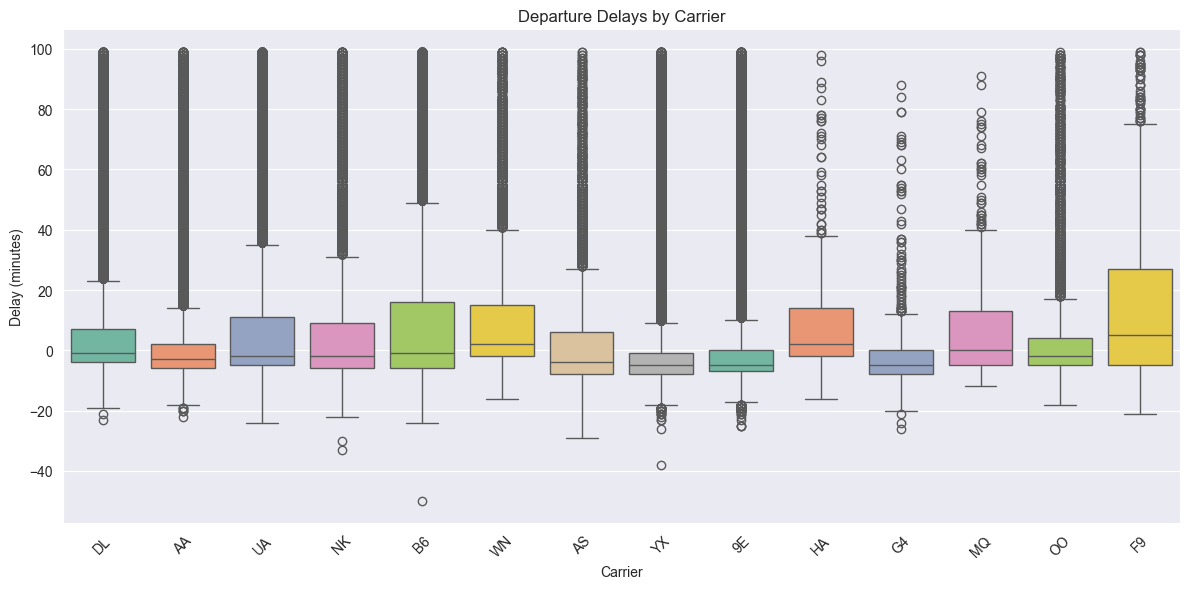

In [842]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df[merged_df['dep_delay'] < 100], x='carrier', y='dep_delay', palette="Set2", color="orange")

plt.title("Departure Delays by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Delay (minutes)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

There is a clear observable dependency between carriers and delays (we cropped the data not to include delays over 100 minutes for visual representation).

Finally, seeing a correlation matrix for delays can be beneficial to see if there are any more dependencies worth investigating.

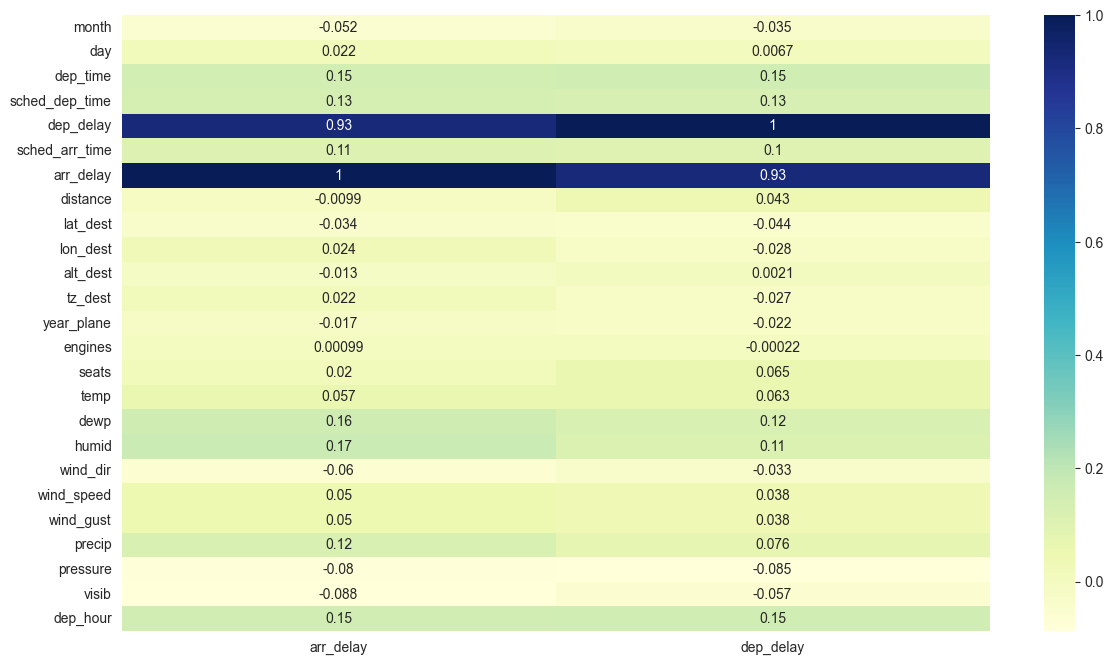

In [843]:
corr_df = merged_df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(14, 8))
sns.heatmap(data=corr_df[['arr_delay', 'dep_delay']], annot=True, cmap='YlGnBu')

plt.show()

Apart from weather conditions, which we considered unreliable, there is no meaningful correlation with other variables.

## Cancellations
We performed similar analysis for cancellations.

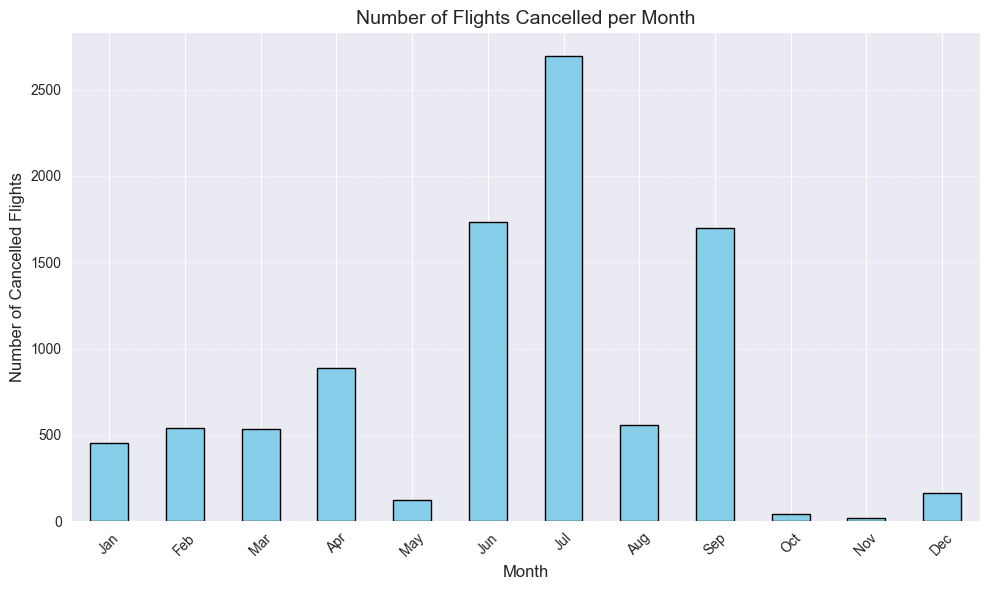

In [844]:
flights_canceled = merged_df[merged_df['is_cancelled']]
monthly_cancellations = flights_canceled.groupby('month').size()

plt.figure(figsize=(10, 6))
monthly_cancellations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Flights Cancelled per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Cancelled Flights', fontsize=12)
plt.xticks(ticks=range(12), labels=[f'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()